# Fine-Tuning OpenCLIP

This notebook is an implementation of [OpenCLIP](https://github.com/mlfoundations/open_clip) finetuning with [WiSE-FT](https://github.com/mlfoundations/wise-ft) method for the Austrian Science Fund funded Ottoman Nature in Travelogues [(ONiT) project](https://onit.oeaw.ac.at/).

After unsuccessfull experiments done with fine-tuning of a linear classifier on top of OpenCLIP, the final version of this notebook implements contrastive learning fine-tuning of an OpenCLIP model (ViT-B-32 pretrained on the LAION 400m dataset) with a sub-set of the [ICONCLASS AI Test Set](https://iconclass.org/testset/) adapted for this task. The subset used for this fine-tuning contains caption-image pairs of the ICONCLASS AI Test Set images featuring nature representations (i.e., flora, fauna, landscapes, and maps). The fine-tuned model is used for image similarity and natural language prompt search of nature representations in the image corpus extracted from the printed travelogues.

Code in this notebook was adapted from [Interacting with openCLIP](https://github.com/mlfoundations/open_clip/blob/main/docs/Interacting_with_open_clip.ipynb) with elements adapted from code generated with ChatGPT (free version). Code for the training was adapted from vinson2233 ([CLIP Training Code #83](https://github.com/openai/CLIP/issues/83)) and Silvia Poletti (AIT Austrian Institute of Technology).

In [1]:
# Import packages
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
import torch.distributed as dist
from PIL import Image
import pandas as pd
import os
import numpy as np
import math
import open_clip
from tqdm.notebook import tqdm
import time
from torch.utils.tensorboard import SummaryWriter
import random

## Load pre-trained model

In [2]:
# Fine-Tuning done with ViT-B-32 model pre-trained on LAION 400m dataset by using mixed precision training

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # If using 1 GPU then use mixed precision training
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion400m_e31', device=device, jit=False) #Must set jit=False for training

## Image preprocessing parameters

In [3]:
# Import image preprocessing packages
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

# Define custom image preprocessing parameters
BATCH_SIZE = 128
IMAGE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
train_val_split_ratio = 0.8 # 80/20 ratio for training/validation data

# Define pad function (add black borders to keep aspect ratio)
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'constant')

# Define custom preprocess function
preprocess = transforms.Compose([
    SquarePad(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

# Define preprocess for preview
preprocess_preview = transforms.Compose([
    SquarePad(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    #transforms.Normalize(MEAN, STD)
])


## Text preprocessing: Load tokenizer

In [4]:
# Import text preprocessing packages
from open_clip import tokenizer

tokenizer = open_clip.get_tokenizer('ViT-B-32')

## Load data

In [5]:
# Data paths
img_dir = 'images'
data_subset_csv = 'nature_subset_cleaned4FT_GT.csv'

onit_data_dir = 'ONiT_data/'
onit_full_csv = 'ONiT_data/ONiT_cleaned-images_D-E-L-F-curated_2024-05-23.csv'

In [6]:
# Load training data from CSV file with filenames, captions, and image paths
data_full = pd.read_csv(data_subset_csv, sep='|', na_filter=False)
data_full = data_full.dropna()

onit_data = pd.read_csv(onit_full_csv, sep=',', na_filter=False)

# Load the image paths, filenames, and captions from a CSV file into lists
image_filenames = data_full["filename"].tolist()
image_captions = data_full["annotation"].tolist()
labels = data_full["label"].tolist()
labels_num = []

for label in data_full["class number"]:
    if isinstance(label, int):
        labels_num.append('[', label, ']')
    elif isinstance(label, str):
        # Handle comma-separated values within a string
        label_list = [int(x.strip()) for x in label.split(',') if x.strip().isdigit()]
        labels_num.append(label_list)

from sklearn import preprocessing
mlb = preprocessing.MultiLabelBinarizer()
#mlb.fit(['1', '2', '3', '4'])
labels_num = mlb.fit_transform(labels_num)
labels_num = labels_num[:, :-1]
#print(labels_num)
print(labels_num.shape)
print(len(labels))

(22716, 4)
22716


In [7]:
# Load training data image paths
image_paths = []
for image_filename in image_filenames:
    img_path = os.path.join(img_dir, image_filename)
    image_paths.append(img_path)

print(len(image_paths))

22716


In [8]:
# Load ONiT data
onit_filenames = []
onit_paths = []
lang_year = []

# Load image paths
for index, row in onit_data.iterrows():
    onit_filename = row["filename"]

    if onit_filename[9] == "_":
        barcode = onit_filename[:9]        
    else:
        barcode = onit_filename[:10]
        
    onit_tag = row["lang_year"]
    onit_path = os.path.join(onit_data_dir, onit_tag, barcode, onit_filename)
    onit_paths.append(onit_path)
    onit_filenames.append(onit_filename)
    lang_year.append(onit_tag)

print(len(onit_filenames))
print(len(onit_paths))

8371
8371


In [9]:
data_full

filename  \
0      embhab_hab_li77441_pic142.jpg   
1               IIHIM_-739492654.jpg   
2         embepu_su1724_pic10005.jpg   
3              IIHIM_-1674073675.jpg   
4              IIHIM_-1186622624.jpg   
...                              ...   
22711     IIHIM_RIJKS_-808802799.jpg   
22712      IIHIM_RIJKS_642351449.jpg   
22713     IIHIM_RIJKS_1638784261.jpg   
22714            128c4_172v_173r.jpg   
22715    IIHIM_RIJKS_-2135779072.jpg   

                                              annotation  \
0                      Image depicting hourglass, animal   
1                                 Image depicting insect   
2      Image depicting perfection, soul, Divotione, R...   
3      Image depicting hunter, huntress, conversation...   
4      Image depicting Mostri, animal, monster, shape...   
...                                                  ...   
22711          Image depicting globe, tool, writing tool   
22712                               Image depicting city   
22713             Image depicting city, battle, fortress   
22714     Image depicting latitude, longitude, continent   
22715  Image depicting country, region, city, battle,...   

                                       path  index      label class number  
0      images/embhab_hab_li77441_pic142.jpg      2  'animals'            1  
1               images/IIHIM_-739492654.jpg      3  'animals'            1  
2         images/embepu_su1724_pic10005.jpg      4  'animals'            1  
3              images/IIHIM_-1674073675.jpg      6  'animals'            1  
4              images/IIHIM_-1186622624.jpg      7  'animals'            1  
...                                     ...    ...        ...          ...  
22711     images/IIHIM_RIJKS_-808802799.jpg  34717     'maps'            4  
22712      images/IIHIM_RIJKS_642351449.jpg  34718     'maps'            4  
22713     images/IIHIM_RIJKS_1638784261.jpg  34721     'maps'            4  
22714            images/128c4_172v_173r.jpg  34722     'maps'            4  
22715    images/IIHIM_RIJKS_-2135779072.jpg  34724     'maps'            4  

[22716 rows x 6 columns]

## Define dataset class and data loader

In [10]:
# Define dataset classes
class IconclassDataset(Dataset):
    def __init__(self, image_paths, image_captions, transform=None):
        self.image_paths = image_paths
        self.image_captions = image_captions
        self.preprocess = preprocess
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        caption = self.image_captions[idx]
        image_path = self.image_paths[idx]
        try:
            with open(image_path, 'rb') as f:
                image = Image.open(f).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image file {image_path} not found. Skipping...")
            pass
        image_prep = preprocess(image)
        caption_prep = tokenizer(caption)[0]
        return image_prep, caption_prep

class OnitFull(Dataset):
    def __init__(self, onit_paths, transform=None):
        self.onit_paths = onit_paths
        self.preprocess = preprocess

    def __len__(self):
        return len(self.onit_paths)

    def __getitem__(self, idx):
        image_path = self.onit_paths[idx]
        try:
            with open(image_path, 'rb') as f:
                image = Image.open(f).convert("RGB")
                image_prep = preprocess(image)
                return image_prep
        except FileNotFoundError:
            print(f"Warning: Image file {image_path} not found. Skipping...")
            pass

In [11]:
# Define datasets
dataset = IconclassDataset(image_paths, image_captions)
onit_full_dataset = OnitFull(onit_paths)

# Split training data into training and validation data sets
## Total samples length
total_samples = len(image_paths)

## Calculate the sizes of the training and validation sets
train_size = int(train_val_split_ratio * total_samples)
val_size = int((total_samples - train_size)/2)
test_size = int((total_samples - train_size)/2)

## Set a fixed random seed
random_seed = 42

# Use random_split to create training and validation datasets
## For fine-tuning of CLIP use dataset (loads image-caption pairs)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(random_seed))

# Define data loaders for training, validation, and test data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Data loader for ONiT images
onitdata_loader = DataLoader(onit_full_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Total dataset size: {len(dataset)}')
print(f'Training dataset size: {train_size}')
print(f'Validation dataset size: {val_size}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Batch size: {BATCH_SIZE}')
print(f'Number of batches ICONCLASS training data loader: {len(train_loader)}')
print(f'Number of batches ICONCLASS validation and test data loaders: {len(val_loader)}')
print('----')
print(f'ONiT curated dataset size: {len(onit_full_dataset)}')
print(f'Number of batches ONiT data loader: {len(onitdata_loader)}')

Total dataset size: 22716
Training dataset size: 18172
Validation dataset size: 2272
Test dataset size: 2272
Batch size: 128
Number of batches ICONCLASS training data loader: 142
Number of batches ICONCLASS validation and test data loaders: 18
----
ONiT curated dataset size: 8371
Number of batches ONiT data loader: 66


## Preview Training Data

In [12]:
import matplotlib.pyplot as plt
import textwrap

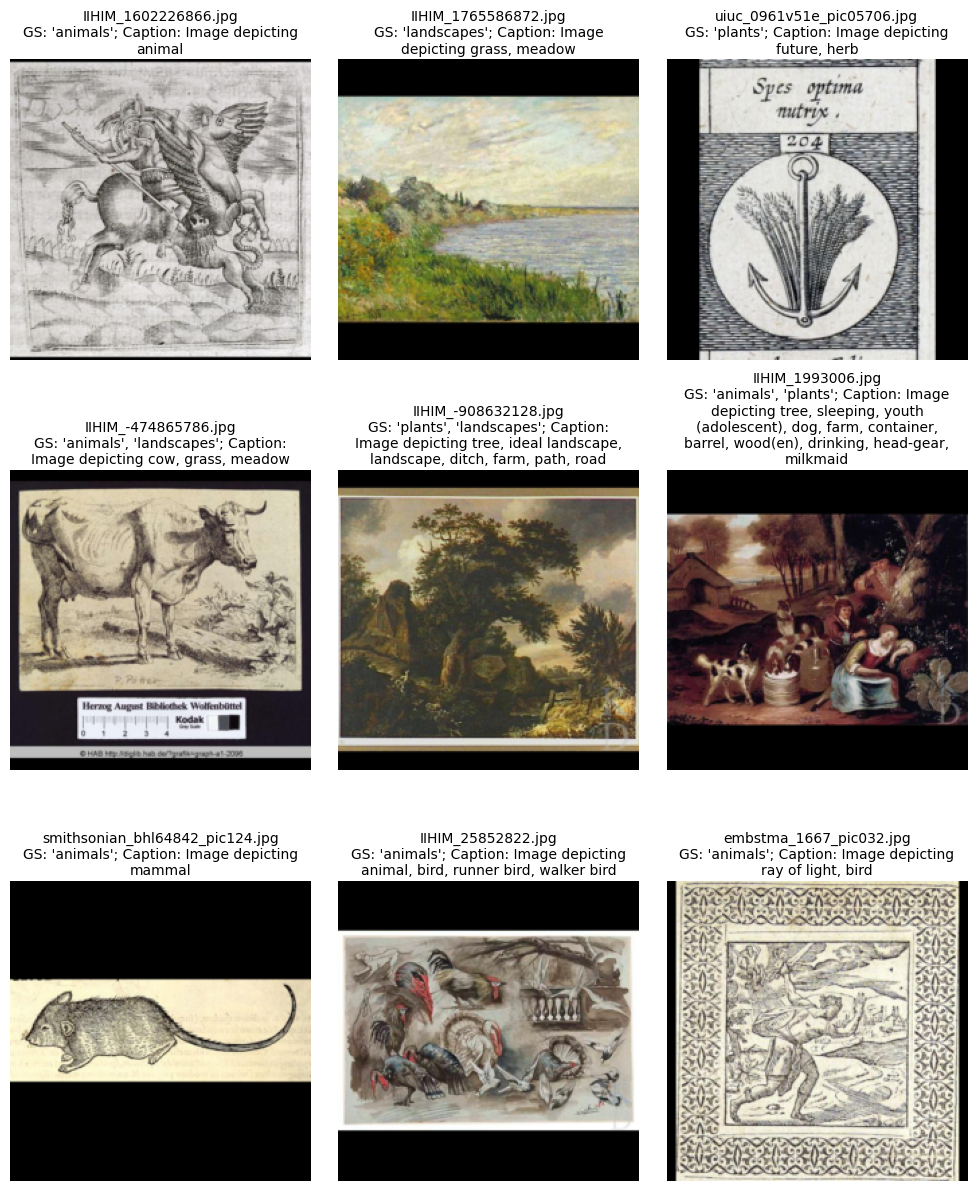

In [13]:
# Define the number of rows and columns in the preview table
num_rows = 3
num_cols = 3
num_images = num_rows * num_cols

# Shuffle the indices of the images and captions from the full dataset
indices = list(range(len(image_paths)))
random.shuffle(indices)

# Load the images and captions for the preview and results tables
images = []
indx = []
for i, index in enumerate(indices[:num_images]):
    image = Image.open(image_paths[index]).convert("RGB")
    #print('Image path: ', image_paths[index])
    images.append(image)
    indx.append(index)
    if i == num_images - 1:
        break

# Create lists of captions, filenames, groundtruth, and classnumber of the set of images
captions = [image_captions[index] for index in indices[:num_images]]
filenames = [image_filenames[index] for index in indices[:num_images]]
groundtruth = [labels[index] for index in indices[:num_images]]
#classnumber = [class_number[index] for index in indices[:num_images]]

# Preprocess the images with the torchvision transform
preprocessed_images = torch.stack([preprocess_preview(image) for image in images])

# Create the preview table
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 12))
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(preprocessed_images[i].permute(1, 2, 0))
    ax.axis("off")
    
    # Add the label as the title
    longtitle = '\n'.join(textwrap.wrap('GS: ' + groundtruth[i] + '; Caption: ' + captions[i], width=40))
    filename = filenames[i]
    title = ax.set_title(filename + "\n" + longtitle, fontsize=10, clip_on=True, wrap=True)
    title.set_position([.5, .9])

# Adjust the spacing between the subplots
fig.subplots_adjust(hspace=0.5)

# Show the preview table
plt.tight_layout()
plt.show()

## Fine-tuning parameters

In [14]:
# Finetuning parameters
LR=5e-5 ## learning rate
EPOCHS = 20
num_batches = len(train_loader)
weight_decay= 0.2
num_classes = 4

SAVE_MODEL = 'CLIP-finetune/models/' # Specify path to save fine-tuned model

# TensorBoard writer
writer = SummaryWriter(log_dir=SAVE_MODEL)

In [15]:
for param in model.parameters():
    param.requires_grad = True # Fine-tune full model without frozen parameters
    
# Freezing selected layers
for name, param in model.named_parameters():
    if 'resblocks.11' in name:
        param.requires_grad = True # Set to true to train selected model parameters
    elif 'resblocks.10' in name:
        param.requires_grad = True # Set to true to train selected model parameters
    else:
        param.requires_grad = False # Freeze all other parameters (set to false)

In [16]:
# Define optimizer and loss function
params = [p for p in model.parameters() if p.requires_grad] #filters out only the parameters that require gradients, and these are the parameters that the optimizer will update during the training process.
optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=weight_decay)
loss_fn = torch.nn.CrossEntropyLoss()

In [17]:
class FTModel(nn.Module):
    def __init__(self, model):
        super(FTModel, self).__init__()
        self.model = model
        #self.fc = nn.Linear(hidden_layer.out_features, num_classes)

    def forward(self, images, captions):
        image_outputs = self.model.encode_image(images)
        caption_outputs = self.model.encode_text(captions)
        
        #print('Image outputs shape: ', image_outputs.shape)
        #print('Caption outputs shape: ', caption_outputs.shape)
        return image_outputs, caption_outputs

finetune_model = FTModel(model)
#print(finetune_model)

In [18]:
devices = list(range(torch.cuda.device_count()))

print('Using devices', devices)
print('Torch CUDA device count: ', torch.cuda.device_count())

Using devices [0]
Torch CUDA device count:  1


# End-to-End Fine-Tuning OpenCLIP

In [19]:
# Automatic mixed precision fine-tuning end-to-end
scaler = GradScaler()

print('Fine-tuning end-to-end')
print(f"Batch Size: {BATCH_SIZE}")
print(f"Training Dataset Size: {train_size}")
model = finetune_model
train_loader = train_loader
val_loader = val_loader

### ML training and validation code partially adapted from Silvia Poletti ###

## TRAINING ##
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    # Create the progress bar
    data_loader_iter = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS}", leave=True, dynamic_ncols=False)
    
    for batch_idx, (image_prep, caption_prep) in enumerate(data_loader_iter):
        start_time = time.time()
        
        optimizer.zero_grad()
        
        images = image_prep.to(device)
        captions = caption_prep.to(device)
        data_time = time.time() - start_time

        with autocast():
            outputs = model(images, captions)
            logits_per_image = outputs[0]
            logits_per_caption = outputs[1]
            
            ### Computation of ground_truth and contrastive loss taken from https://github.com/openai/CLIP/issues/83
            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
            loss = (loss_fn(logits_per_image,ground_truth) + loss_fn(logits_per_caption,ground_truth))/2 # Compute contrastive loss

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        torch.nn.utils.clip_grad_norm_(params, 1.0)
        
        running_loss += loss.item()
        batch_time = time.time() - start_time

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            writer.add_scalar("Training Loss (over the batches)", loss.item(), epoch * len(train_loader) + batch_idx)

        if i % 100 == 0:
            percent_complete = 100 * i / len(data_loader)
            print(
                f"Loss: {loss.item():.6f}\tData (t) {data_time:.3f}\tBatch (t) {batch_time:.3f}", flush=True
            )
    running_loss /= len(train_loader)

    writer.add_scalar("Training Loss (over the epochs)", running_loss, epoch)
    print("\nTraining Loss", running_loss)

    ## Validation ##
    model.eval()
    val_loss = 0.0

    val_loader_iter = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{EPOCHS}", leave=True, dynamic_ncols=False)

    with torch.no_grad():
        for batch_idx, (image_prep, caption_prep) in enumerate(val_loader_iter):
            images = image_prep.to(device)
            captions = caption_prep.to(device)
            val_time = time.time() - start_time

            outputs = model(images, captions)
            logits_per_image = outputs[0]
            logits_per_caption = outputs[1]

            ### Computation of ground_truth and contrastive loss taken from https://github.com/openai/CLIP/issues/83 ###
            ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
            loss = (loss_fn(logits_per_image,ground_truth) + loss_fn(logits_per_caption,ground_truth))/2 # Compute contrastive loss
            val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(val_loader):
                writer.add_scalar("Validation Loss (over the batches)", loss.item(), epoch * len(val_loader) + batch_idx)

    val_loss /= len(val_loader)
    # val_accuracy = correct / total
    
    writer.add_scalar("Validation Loss (over the epochs)", val_loss, epoch)
    # writer.add_scalar("Validation Accuracy (over the epochs)", val_accuracy, epoch)
    print("\nValidation Loss", val_loss)
    # print("\nValidation Accuracy: ", val_accuracy)

Fine-tuning end-to-end
Batch Size: 128
Training Dataset Size: 18172


Training Epoch 1/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.752983986491889


Validation Epoch 1/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.693429734971788


Training Epoch 2/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.692257669610037


Validation Epoch 2/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.691505776511298


Training Epoch 3/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.690793285907154


Validation Epoch 3/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.690162102381389


Training Epoch 4/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.690004949838343


Validation Epoch 4/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.689348538716634


Training Epoch 5/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.689490402248544


Validation Epoch 5/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688920974731445


Training Epoch 6/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.689205512194566


Validation Epoch 6/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688740809758504


Training Epoch 7/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.6890641467672


Validation Epoch 7/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688650422626072


Training Epoch 8/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.6889183622010995


Validation Epoch 8/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688661707772149


Training Epoch 9/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.688930592066805


Validation Epoch 9/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688446998596191


Training Epoch 10/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.6887937129383355


Validation Epoch 10/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688366969426473


Training Epoch 11/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.6887684741490325


Validation Epoch 11/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.68860575887892


Training Epoch 12/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.6886241671065205


Validation Epoch 12/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688540432188246


Training Epoch 13/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.688699668561909


Validation Epoch 13/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688455767101711


Training Epoch 14/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.688556261465583


Validation Epoch 14/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688320769204034


Training Epoch 15/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.688512174176498


Validation Epoch 15/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688375075658162


Training Epoch 16/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.688517664519834


Validation Epoch 16/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688338836034139


Training Epoch 17/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.688397622444261


Validation Epoch 17/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688216341866387


Training Epoch 18/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.688519521498344


Validation Epoch 18/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688213056988186


Training Epoch 19/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.688388965499233


Validation Epoch 19/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.688389645682441


Training Epoch 20/20:   0%|          | 0/142 [00:00<?, ?it/s]


Training Loss 5.688434338905442


Validation Epoch 20/20:   0%|          | 0/18 [00:00<?, ?it/s]


Validation Loss 5.68836694293552


In [20]:
# Save the fine-tuned model

os.makedirs(SAVE_MODEL, exist_ok=True)

print('Saving model to ', SAVE_MODEL, f"finetuned_clip_ViT-B-32_resblocks10-11_{epoch+1}.pt")
torch.save(model, os.path.join(SAVE_MODEL, f"finetuned_clip_ViT-B-32_resblocks10-11_{epoch+1}.pt"))

Saving model to  CLIP-finetune/models/ finetuned_clip_ViT-B-32_resblocks10-11_20.pt


## Interpolate fine-tuned and zero-shot weights (WiSE-FT)

In [21]:
### Code adapted from https://github.com/mlfoundations/wise-ft ###

# interpolation coefficient
alpha = 0.5

'Interpolation coefficient for ensembling. '
'Users should specify N-1 values, where N is the number of '
'models being ensembled. The specified numbers should sum to '
'less than 1. Note that the order of these values matter, and '
'should be the same as the order of the classifiers being ensembled.'

'should be the same as the order of the classifiers being ensembled.'

In [22]:
# Load fine-tuned and zero-shot model checkpoints

print('Load fine-tuned full model checkpoint')
finetuned_checkpoint = os.path.join(SAVE_MODEL, f"finetuned_clip_ViT-B-32_resblocks10-11_{epoch+1}.pt")
zeroshot = FTModel(open_clip.create_model('ViT-B-32', pretrained='laion400m_e31', device=device, jit=False))

finetuned = torch.load(finetuned_checkpoint)
#print(finetuned)

Load fine-tuned full model checkpoint


In [23]:
print(len(zeroshot.state_dict().keys()))
print(len(finetuned.state_dict().keys()))

302
302


In [24]:
# Compute interpolation
theta_0 = zeroshot.state_dict()
theta_1 = finetuned.state_dict()

# make sure checkpoints are compatible
assert set(theta_0.keys()) == set(theta_1.keys())

# interpolate between checkpoints with mixing coefficient alpha
theta = {
    key: (1-alpha) * theta_0[key] + alpha * theta_1[key]
    for key in theta_0.keys()
}

# update the model acccording to the new weights
finetuned.load_state_dict(theta)


<All keys matched successfully>

In [25]:
# save model

print('Saving interpolated model to ', SAVE_MODEL, f'clip_ViT-B-32_FTresblocks10-11_wise_ft_alpha={alpha:.3f}.pt')
torch.save(finetuned, os.path.join(SAVE_MODEL, f'clip_ViT-B-32_FTresblocks10-11_wise_ft_alpha={alpha:.3f}.pt'))

Saving interpolated model to  CLIP-finetune/models/ clip_ViT-B-32_FTresblocks10-11_wise_ft_alpha=0.500.pt


# Explore Similarity

## Get Features

In [26]:
# Load fine-tuned model

finetuned_checkpoint = os.path.join(SAVE_MODEL, "clip_ViT-B-32_FTresblocks10-11_wise_ft_alpha=0.500.pt")

model = torch.load(finetuned_checkpoint, map_location=torch.device(device))

# Load pre-trained model
#model, _, _ = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion400m_e31', device=device)

In [27]:
# Get features of ONiT dataset with loaded image encoder of fine-tuned/pre-trained model

EMBEDDINGS = 'CLIP-finetune/embeddings/' # Specify path to save embeddings

# Get Features function
def get_features(onit_full_dataset):
    image_features = []

    with torch.no_grad():
        for image_prep in tqdm(onitdata_loader):
            #print('Images: ', image_prep.shape)
            imfeat = model.model.encode_image(image_prep.to(device)) ## Fine-tuned model
            #imfeat = model.encode_image(image_prep.to(device)) ## Pre-trained model
            
            image_features.append(imfeat)

    return torch.cat(image_features).cpu().numpy()

# Calculate image features
image_features = get_features(onit_full_dataset)

  0%|          | 0/66 [00:00<?, ?it/s]

In [28]:
os.makedirs(EMBEDDINGS, exist_ok=True)

features_path = os.path.join(EMBEDDINGS, "onit_curated_image_embeddings_clip_ViT-B-32_FTresblocks10-11_wise_ft.npy")
np.save(features_path, image_features)

## Search for similar images

In [29]:
loaded_image_features = np.load(features_path)
image_embeddings = torch.tensor(loaded_image_features, device='cpu')

# Image similarity
from sklearn.metrics.pairwise import cosine_similarity

In [30]:
loaded_image_features.shape

(8371, 512)

torch.Size([1, 512])
torch.Size([8371, 512])


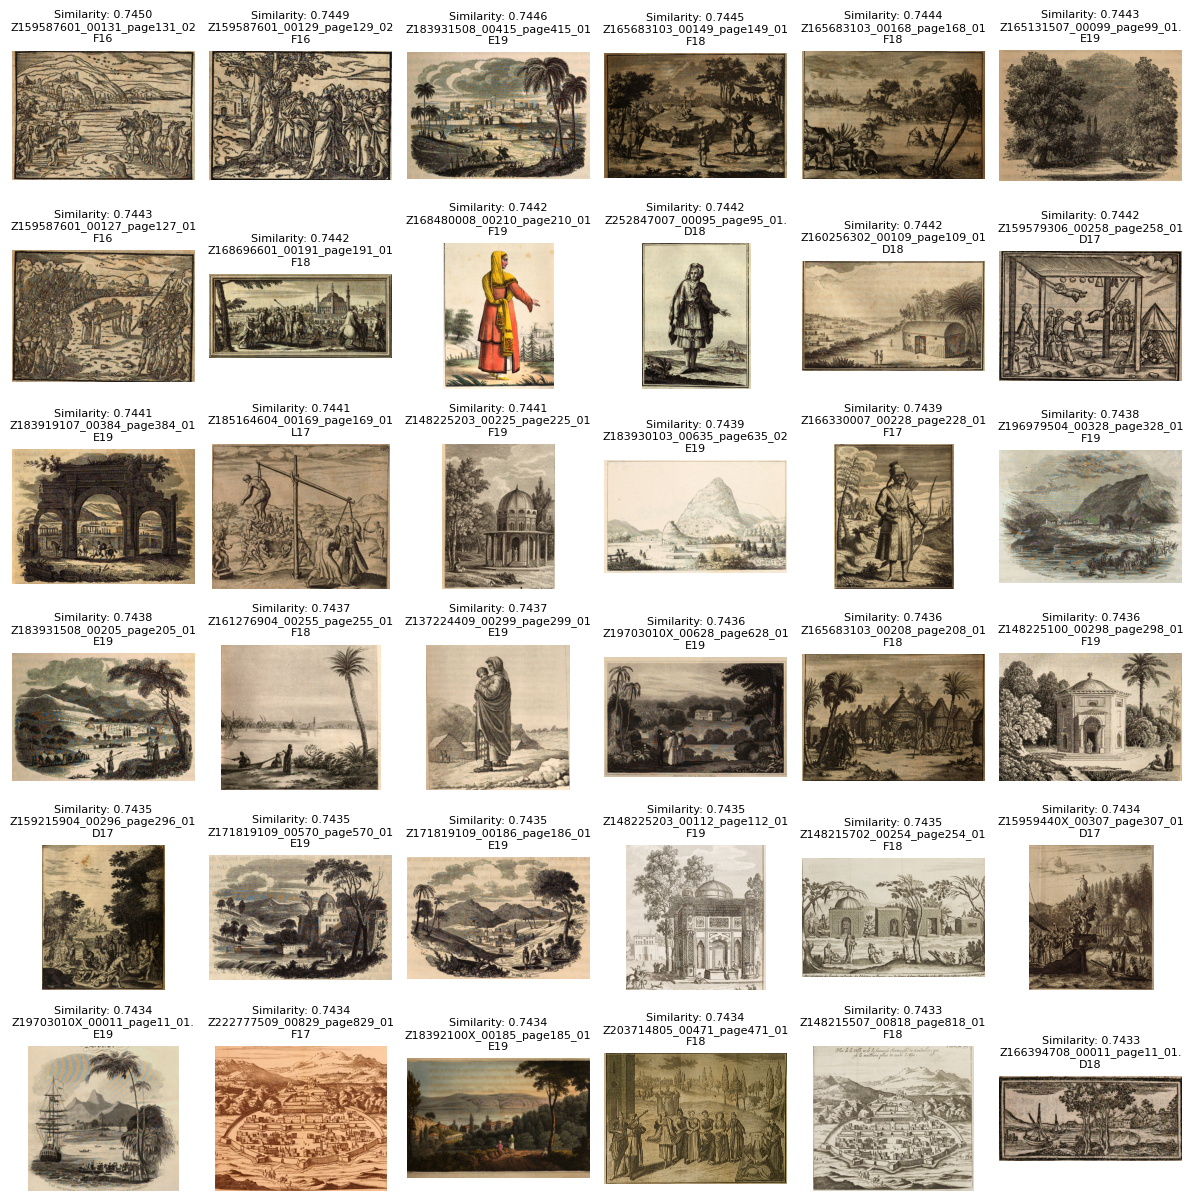

In [32]:
# Text prompt describing the type of images you are looking for
#text_prompt = "An image of an animal"
#text_prompt = "An image of a plant"
text_prompt = "An image of a landscape"
#text_prompt = "An image of a map"

#text_prompt = "An image of a horse"
#text_prompt = "An image of a camel"
#text_prompt = "An image of a bird"
#text_prompt = "An image of a dog"
#text_prompt = "An image of a cat"
#text_prompt = "An image of a giraffe"

# Encode the text prompt to get the text embedding
with torch.no_grad():
    text_embedding = model.model.encode_text(tokenizer(text_prompt).to(device)) #for fine-tuned model
    #text_embedding = model.encode_text(tokenizer(text_prompt).to(device)) #for original CLIP model

print(text_embedding.shape)
print(image_embeddings.shape)

# Compute the cosine similarity between the text prompt and all images
similarities = cosine_similarity(text_embedding.cpu(), image_embeddings.cpu())
similarities_tensor = torch.tensor(similarities[0], device=device)

# Sort the images based on similarity (descending order)
similar_images_indices = torch.argsort(similarities_tensor, descending=True)

# Load the images for visualization
top_n = 36  # Show the top 16 similar images
fig, axes = plt.subplots(6, 6, figsize=(12, 12))

for i in range(top_n):
    index = similar_images_indices[i].item()
    image_path = onit_paths[index]
    image = Image.open(image_path)
    
    # Plot the image
    axes[i // 6, i % 6].imshow(image)
    axes[i // 6, i % 6].axis("off")
    
    # Set the title with two lines
    axes[i // 6, i % 6].set_title(f"Similarity: {similarities_tensor[similar_images_indices[i]]:.4f}\n{(onit_filenames[index])[:27]}\n{(lang_year[index])}", fontsize=8)

plt.tight_layout()
plt.show()

## Analyse Training Data

### Visualise label distribution of ICONCLASS Nature Subset used for training

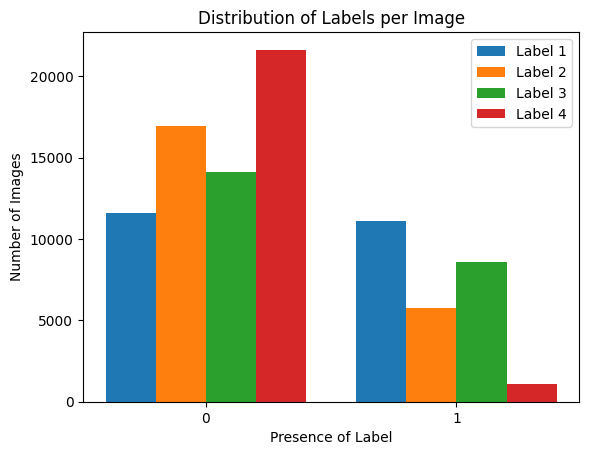

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming labels_num is a 2D array where each row corresponds to labels for an image
labels_transposed = labels_num.T

# Plot separate histograms for each label
fig, ax = plt.subplots()

width = 0.2  # Adjust as needed
for label_idx, label_values in enumerate(labels_transposed):
    unique_values, counts = np.unique(label_values, return_counts=True)
    ax.bar(unique_values + label_idx * width, counts, width=width, label=f'Label {label_idx + 1}')

ax.set_xlabel('Presence of Label')
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Labels per Image')
ax.set_xticks(np.arange(len(unique_values)) + width * (len(labels_transposed) - 1) / 2)
ax.set_xticklabels(unique_values)
ax.legend()

plt.show()

# Legend
# Label 1 = animals
# Label 2 = plants
# Label 3 = landscapes
# Label 4 = maps

In [36]:
# Common labels

import numpy as np

# Assuming labels_num is a 2D array where each row corresponds to labels for an image

# Count occurrences of each label across all images
label_counts = np.sum(labels_num, axis=0)

# Display top N common labels
top_n = 4  # Adjust as needed
top_labels = np.argsort(label_counts)[::-1][:top_n]

print(f"Top {top_n} Common Labels:")
for label_idx in top_labels:
    print(f"Label {label_idx + 1}: {label_counts[label_idx]} occurrences")
    

Top 4 Common Labels:
Label 1: 11105 occurrences
Label 3: 8594 occurrences
Label 2: 5752 occurrences
Label 4: 1075 occurrences


In [37]:
# Label co-occurrence

import numpy as np

# Assuming labels_num is a 2D array where each row corresponds to labels for an image

# Calculate label co-occurrence matrix
label_co_occurrence = np.dot(labels_num.T, labels_num)

print("Label Co-occurrence Matrix:")
print(label_co_occurrence)

# Interpretation:
# - Label 1 appears alone 11,105 times.
# - Label 2 appears alone 5,752 times.
# - Label 3 appears alone 8,594 times.
# - Label 4 appears alone 1,075 times.
# - Labels 1 and 2 co-occur 751 times.
# - Labels 1 and 3 co-occur 2,030 times.
# - Labels 1 and 4 co-occur 106 times.
# - Labels 2 and 3 co-occur 1,169 times.
# - Labels 2 and 4 co-occur 28 times.
# - labels 3 and 4 co-occur 64 times.

Label Co-occurrence Matrix:
[[11105   751  2030   106]
 [  751  5752  1169    28]
 [ 2030  1169  8594    64]
 [  106    28    64  1075]]


In [38]:
# Label statistics per image

import numpy as np

# Assuming labels_num is a 2D array where each row corresponds to labels for an image

# Calculate mean, median, and standard deviation of labels per image
mean_labels = np.mean(np.sum(labels_num, axis=1))
median_labels = np.median(np.sum(labels_num, axis=1))
std_labels = np.std(np.sum(labels_num, axis=1))

print(f"Mean Labels per Image: {mean_labels}")
print(f"Median Labels per Image: {median_labels}")
print(f"Standard Deviation of Labels per Image: {std_labels}")

Mean Labels per Image: 1.1677231907025885
Median Labels per Image: 1.0
Standard Deviation of Labels per Image: 0.4115226389255673
